In [ ]:
# Copyright (c) 2025, NVIDIA CORPORATION.  All rights reserved.
#
# NVIDIA CORPORATION and its licensors retain all intellectual property
# and proprietary rights in and to this software, related documentation
# and any modifications thereto.  Any use, reproduction, disclosure or
# distribution of this software and related documentation without an express
# license agreement from NVIDIA CORPORATION is strictly prohibited.

# Example run of SVRaster

## Installation

Create virtual environment for running jupyter notebook.
```bash
conda create -n svr_jupyter python=3.9
conda activate svr_jupyter
```

Install jupyter notebook dependency.
```bash
pip install -U notebook
```

Install dependency for SVRaster. The tested Pytorch versions is `2.5.0+cu124`.
```bash
pip install torch==2.5.0 torchvision==0.20.0 torchaudio==2.5.0 --index-url https://download.pytorch.org/whl/cu124
conda install -y -c "nvidia/label/cuda-12.4.0" cuda-toolkit
pip install -r requirements.txt
pip install cuda/
```

Starting jupyter at server side.
```bash
jupyter notebook --no-browser --port=7007
```

In case the server port is not accessible, use ssh port forwarding on your personal computer.
```bash
ssh -L 7007:localhost:7007 {SERVER_URL}
```

In [1]:
import os
PROJECT_ROOT = os.path.abspath('../')
print("PROJECT_ROOT:", PROJECT_ROOT)

import sys
sys.path.insert(0, PROJECT_ROOT)

import IPython
from IPython.display import Image, Video
import ipywidgets

import copy
import numpy as np
from glob import glob
import imageio.v3 as iio

import torch

from src.dataloader.data_pack import DataPack
from src.sparse_voxel_model import SparseVoxelModel
from src.cameras import MiniCam

PROJECT_ROOT: /home/chengs/voxworld


## Prepare data
To process your own capturing, we recommend to follow [InstantNGP](https://github.com/NVlabs/instant-ngp/blob/master/docs/nerf_dataset_tips.md#colmap) video or images processing steps to extract camera parameters using COLMAP. [NerfStudio](https://docs.nerf.studio/quickstart/custom_dataset.html) also works. We now only support pinhole camera mode. Please preprocess with `--colmap_camera_model PINHOLE` of InstantNGP script or `--camera-type pinhole` of NerfStudio script.

In the foloowing, we use the `garden` scene processed and maintained by [mipnerf360](https://jonbarron.info/mipnerf360/).

In [2]:
DATA_ROOT = os.path.join(PROJECT_ROOT, 'data', '360_v2', 'garden')
OUTPUT_ROOT = os.path.join(PROJECT_ROOT, 'output', 'tutorial')
print("DATA_ROOT:", DATA_ROOT)
print("OUTPUT_ROOT:", OUTPUT_ROOT)

DATA_ROOT: /home/chengs/voxworld/data/360_v2/garden
OUTPUT_ROOT: /home/chengs/voxworld/output/tutorial


## Scene optimization

```bash
python train.py --eval --source_path $DATA_PATH --model_path $OUTPUT_PATH
```
All the results will be saved into the specified `$OUTPUT_PATH`.
- `config.yaml`: The config file for reproduction.
- `pg_view/`: Visualization of the training progress. Useful for debugging.
- `test_stat/`: Some statistic during the training.
- `test_view/`: Some visualization during the training.

The configuration is defined by the following three, the later overwrites the former.
- `src/config.py`: Define the configuable setup and their initial values.
- `--cfg_files`: Sepcify a list of config files, the later overwrites the former. Some examples are under `cfg/`.
- command line: Any field defined in `src/config.py` can be overwritten through command line. For instances: `--data_device cpu`, `--subdivide_save_gpu`.

Like InstantNGP and other NeRF variants, defining a proper main scene bounding box is crucial to quality and processing time. The main scene bound is defined for the main 3D region of interest. There are another `--outside_level` (default 5) Octree levels for the background region. The default main scene bound heuristic may work well in many cases but you can manually tweak them by the following:
- `--bound_mode`:
    - `default`
        - Use the suggested bbox if given by dataset. Otherwise, it automatically chose from `forward` or `camera_median` modes.
    - `camera_median`
        - Set camera centroid as world origin. The bbox radius is set to the median distance between origin and cameras.
    - `camera_max`
        - Set camera centroid as world origin. The bbox radius is set to the maximum distance between origin and cameras.
    - `forward`
        - Assume [LLFF](https://github.com/Fyusion/LLFF?tab=readme-ov-file#local-light-field-fusion) forward-facing capturing. See `src/utils/bounding_utils.py` for detail heuristic.
    - `pcd`
        - Use COLMAP sparse points to compute a scene bound. See `src/utils/bounding_utils.py` for detail heuristic.
- `--bound_scale`: re-scale the main scene bound.

For object centric scenes with background masked out, use `--white_background` or `--black_background` to specify the background color.

Other hyperparameter suggestions:
- `--lambda_normal_dmean 0.001 --lambda_normal_dmed 0.001` for a better geometry.
- `--lambda_T_inside 0.01` to encourage rays to stop inside the Octree. Useful for real-world scenes.
- `--lambda_T_concen 0.1`  to encourage transmittance to be either 0 or 1. Useful for object centric scenes with background masked out.

In [3]:
# Default work well too
# !(python $PROJECT_ROOT/train.py \
#     --eval \
#     --source_path $DATA_ROOT/db/playroom \
#     --model_path $OUTPUT_ROOT/playroom \
# )

# For a better geometry
!(python $PROJECT_ROOT/train.py \
    --eval \
    --source_path $DATA_ROOT \
    --model_path $OUTPUT_ROOT \
    --lambda_normal_dmean 0.001 --lambda_normal_dmed 0.001 \
)

Output folder: /home/chengs/voxworld/output/tutorial
Read dataset in COLMAP format.
images_folder=/home/chengs/voxworld/data/360_v2/garden/images
res_downscale=0.0
res_width=0
[WARN] Source images are too large (5187x3361). 
       Auto downscale gt by 4.077485483823158. 
       Use `--images`, `--res_downscale`, or `--res_width` to prevent it.
Heuristic bounding: camera_median
Inside bound min: [-3.704894781112671, -3.69096040725708, -3.6718671321868896]
Inside bound max: [3.7344071865081787, 3.7483415603637695, 3.76743483543396]
Inside layout :   173539 voxels,     29/    19/    77 avg avg/min/max samp-rate.
Outside layout:   347077 voxels,     37/    33/    43 avg avg/min/max samp-rate.
Number of points at initialisation: 520616
grid_pts size at initialisation: 568258
Start optmization from iters=1.
Subdiv: times=15 scale-each-time=135.0% prop=5.0%
/home/chengs/voxworld/src/sparse_voxel_gears/adaptive.py:461: UserWarning: index_reduce() is in beta and the API may change at any time.

### Visualize the optimization progress

In [11]:
iio.imwrite(
    f'{OUTPUT_ROOT}/pg_view.mp4',
    [iio.imread(path) for path in sorted(glob(f'{OUTPUT_ROOT}/pg_view/iter*.jpg'))],
    fps=10,
    output_params=['-vf', 'scale=768:-2'])
Video(f'{OUTPUT_ROOT}/pg_view.mp4')

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (2544, 2472) to (2544, 2480) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
Only '-vf scale=768:-2' read, ignoring remaining -vf options: Use ',' to separate filters


### Measure FPS

In [5]:
!python $PROJECT_ROOT/render.py $OUTPUT_ROOT --eval_fps

Rendering /home/chengs/voxworld/output/tutorial
Read dataset in COLMAP format.
images_folder=/home/chengs/voxworld/data/360_v2/garden/images
res_downscale=0.0
res_width=0
[WARN] Auto downscale gt by 4.077485483823158. 
       Use `--res_downscale` or `--res_width` to prevent it.
render_path: /home/chengs/voxworld/output/tutorial/train/ours_20000/renders
ss            =: 1.5
vox_geo_mode  =: triinterp1
density_mode  =: exp_linear_11
Rendering progress: 100%|████████████████████| 161/161 [00:01<00:00, 119.56it/s]
Resolution: (824, 1272)
Eps time: 1.353 sec
Peak mem: 3.99 GB
FPS     : 119
render_path: /home/chengs/voxworld/output/tutorial/test/ours_20000/renders
ss            =: 1.5
vox_geo_mode  =: triinterp1
density_mode  =: exp_linear_11
Rendering progress: 100%|██████████████████████| 24/24 [00:00<00:00, 121.03it/s]
Resolution: (824, 1272)
Eps time: 0.204 sec
Peak mem: 3.98 GB
FPS     : 118


### Render test-set views

In [6]:
!python $PROJECT_ROOT/render.py $OUTPUT_ROOT --skip_train
!python $PROJECT_ROOT/eval.py $OUTPUT_ROOT

Rendering /home/chengs/voxworld/output/tutorial
Read dataset in COLMAP format.
images_folder=/home/chengs/voxworld/data/360_v2/garden/images
res_downscale=0.0
res_width=0
[WARN] Source images are too large (5187x3361). 
       Auto downscale gt by 4.077485483823158. 
       Use `--images`, `--res_downscale`, or `--res_width` to prevent it.
render_path: /home/chengs/voxworld/output/tutorial/test/ours_20000/renders
ss            =: 1.5
vox_geo_mode  =: triinterp1
density_mode  =: exp_linear_11
Rendering progress: 100%|███████████████████████| 24/24 [00:11<00:00,  2.03it/s]
PSNR: 27.510812679926556
Scene: /home/chengs/voxworld/output/tutorial
Method: ours_20000
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]<?, ?it/s]
/home/chengs/miniconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/chengs/minico

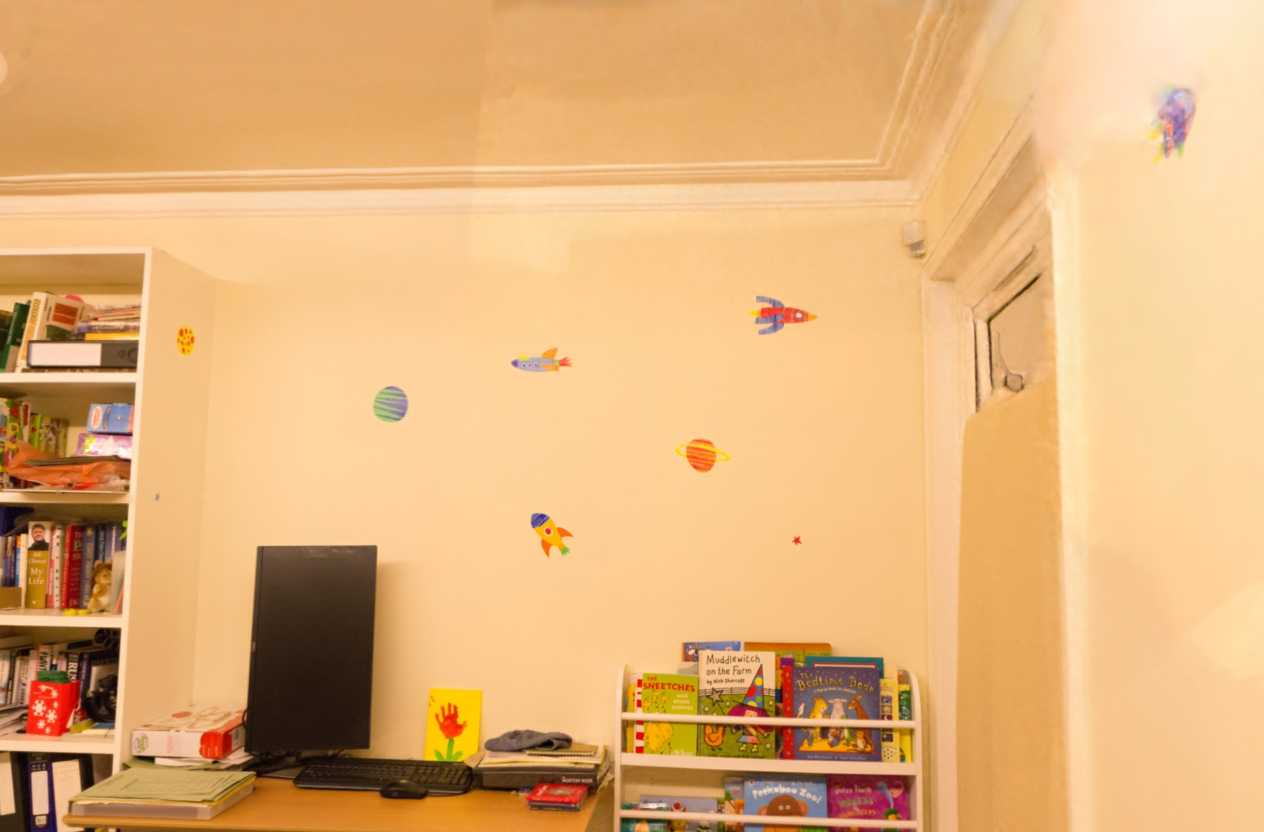

In [7]:
Image(glob(f'{OUTPUT_ROOT}/playroom/test/*/renders/00000.png')[0], width=512)

## Render fly-through video

In [8]:
!python $PROJECT_ROOT/render_fly_through.py $OUTPUT_ROOT

Rendering /home/chengs/voxworld/output/tutorial
Read dataset in COLMAP format.
images_folder=/home/chengs/voxworld/data/360_v2/garden/images
res_downscale=0.0
res_width=0
[WARN] Auto downscale gt by 4.077485483823158. 
       Use `--res_downscale` or `--res_width` to prevent it.
Rendering progress: 100%|█████████████████████| 300/300 [00:03<00:00, 87.61it/s]
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1272, 824) to (1280, 832) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x5c73ec0] Warning: data is not aligned! This can lead to a speed loss
Save to /home/chengs/voxworld/output/tutorial/render_fly_through.mp4


In [9]:
Video(f'{OUTPUT_ROOT}/render_fly_through.mp4')

## Interactive viewer using Kaolin

See [Kaolin installation guide](https://kaolin.readthedocs.io/en/latest/notes/installation.html) for installation. Below is the tested version:
```bash
pip install kaolin==0.14.0 -f https://nvidia-kaolin.s3.us-east-2.amazonaws.com/torch-1.13.1_cu117.html
# or
pip install kaolin==0.17.0 -f https://nvidia-kaolin.s3.us-east-2.amazonaws.com/torch-2.5.0_cu124.html
```

Jupyter extension for interactive viewer. Need to restart the jupyter server after installation.
```bash
conda install -c conda-forge widgetsnbextension
conda install -c conda-forge ipywidgets
```

Note: The FPS of the visualizer is bottleneck by streaming images via network protocal

In [13]:
import kaolin

%load_ext autoreload
%autoreload 2
%matplotlib inline

### Import and define some utility functions

In [14]:
'''
The following utility functions are adapted from:
    [mshugrina/interactive/interactive.ipynb](https://github.com/shumash/gaussian-splatting/blob/mshugrina/interactive/interactive.ipynb).
'''

def compute_cam_fov(intrinsics, axis='x'):
    # compute FOV from focal
    aspectScale = intrinsics.width / 2.0
    tanHalfAngle = aspectScale / (intrinsics.focal_x if axis == 'x' else intrinsics.focal_y).item()
    fov = np.arctan(tanHalfAngle) * 2
    return fov

def convert_from_kaolin_camera(kal_camera):
    """ Convert kaolin camera to our camera. """
    w2c = torch.eye(4, dtype=torch.float32)
    w2c[:3, :3] = kal_camera.extrinsics.R[0]
    w2c[:3, 3] = kal_camera.extrinsics.t.squeeze()
    w2c[1:3] *= -1
    c2w = w2c.inverse().cuda()
    return MiniCam(
        c2w,
        fovx=compute_cam_fov(kal_camera.intrinsics, 'x'),
        fovy=compute_cam_fov(kal_camera.intrinsics, 'y'),
        width=kal_camera.width,
        height=kal_camera.height,
        near=kal_camera.near,
    )

def convert_to_kaolin_camera(our_camera):
    """ Convert our camera to Kaolin camera. """
    view_mat = our_camera.w2c.clone()
    view_mat[1:3] = -view_mat[1:3]
    res = kaolin.render.camera.Camera.from_args(
        view_matrix=view_mat,
        width=our_camera.image_width, height=our_camera.image_height,
        near=our_camera.near,
        fov=our_camera.fovx, device='cpu')
    return res

@torch.no_grad()
def render_kaolin(kaolin_cam):
    cam = convert_from_kaolin_camera(kaolin_cam)
    render_pkg = voxel_model.render(cam)
    im = render_pkg["color"].moveaxis(0, -1).clamp(0, 1).mul(255).to(torch.uint8).cpu()
    return im

### Load checkpoint config

In [20]:
from src.config import cfg, update_argparser, update_config

update_config(f'{OUTPUT_ROOT}/config.yaml')

### Load model

In [21]:
voxel_model = SparseVoxelModel(cfg.model)

# Load the latest
voxel_model.load_iteration(-1)
voxel_model.freeze_vox_geo()

### Load train/test cameras

In [22]:
data_pack = DataPack(cfg.data, camera_params_only=True)

tr_cam_lst = data_pack.get_train_cameras()
te_cam_lst = data_pack.get_test_cameras()

Read dataset in COLMAP format.
images_folder=/home/chengs/voxworld/data/360_v2/garden/images
res_downscale=0.0
res_width=0


### Lanch Kaolin interface for interactive viewing

In [23]:
starting_cam = copy.deepcopy(tr_cam_lst[0])
starting_cam.image_width = 512
starting_cam.image_height = 512

starting_kaolin_cam = convert_to_kaolin_camera(starting_cam)
starting_focus_at = (starting_kaolin_cam.cam_pos() - 4. * starting_kaolin_cam.extrinsics.cam_forward()).squeeze()
starting_up_axis = starting_kaolin_cam.extrinsics.R[0][1].abs().argmax().item()
starting_W = starting_kaolin_cam.width
starting_H = starting_kaolin_cam.height

In [24]:
visualizer = kaolin.visualize.IpyTurntableVisualizer(
    height=starting_H,
    width=starting_W,
    camera=copy.deepcopy(starting_kaolin_cam),
    render=render_kaolin, 
    focus_at=starting_focus_at,
    world_up_axis=starting_up_axis,
    max_fps=12,
)

visualizer.show()

Canvas(height=512, width=512)

Output()